# Imports

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader

from datasets import ModelnetDataset, FromNpDataset
from transforms import SetRotation
from vae import PCVAE
from modelutils import cd

# Prepare dataset

In [2]:
test_dataset = ModelnetDataset(filter=1)
test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=True, num_workers=1)

# Load model

In [3]:
model = PCVAE.load_from_drive(PCVAE, name='bestpcvae')

# Visualize some reconstructions

In [4]:
def zzip(a, b):
    if len(a) == 0:
        return b
    if len(b) == 0:
        return a
    return [a[0], b[0]] + zzip(a[1:], b[1:])

def unstack(t):
    return [x.squeeze(0) for x in list(t.split(1))]

In [5]:
def subplot_num(m, i, j):
    return i*m + j

def draw_pc(ax, pc):
    pc = SetRotation((np.pi/2, -np.pi, 0))(pc)
    X, Y, Z = np.split(pc, 3)
    ax.scatter(X, Y, Z)

def plot_samples(samples, n, m):
    fig = plt.figure(figsize=(4.5*m,4.5*n))
    for i in range(n):
        for j in range(m):
            idx = subplot_num(m, i, j)
            ax = fig.add_subplot(n, m, idx+1, projection='3d')
            draw_pc(ax, samples[idx])    
    plt.show()

In [6]:
batch, _ = next(iter(test_loader))
rec, _ = model(batch)
rec = rec.detach()

batch_rec = zzip(unstack(batch), unstack(rec))

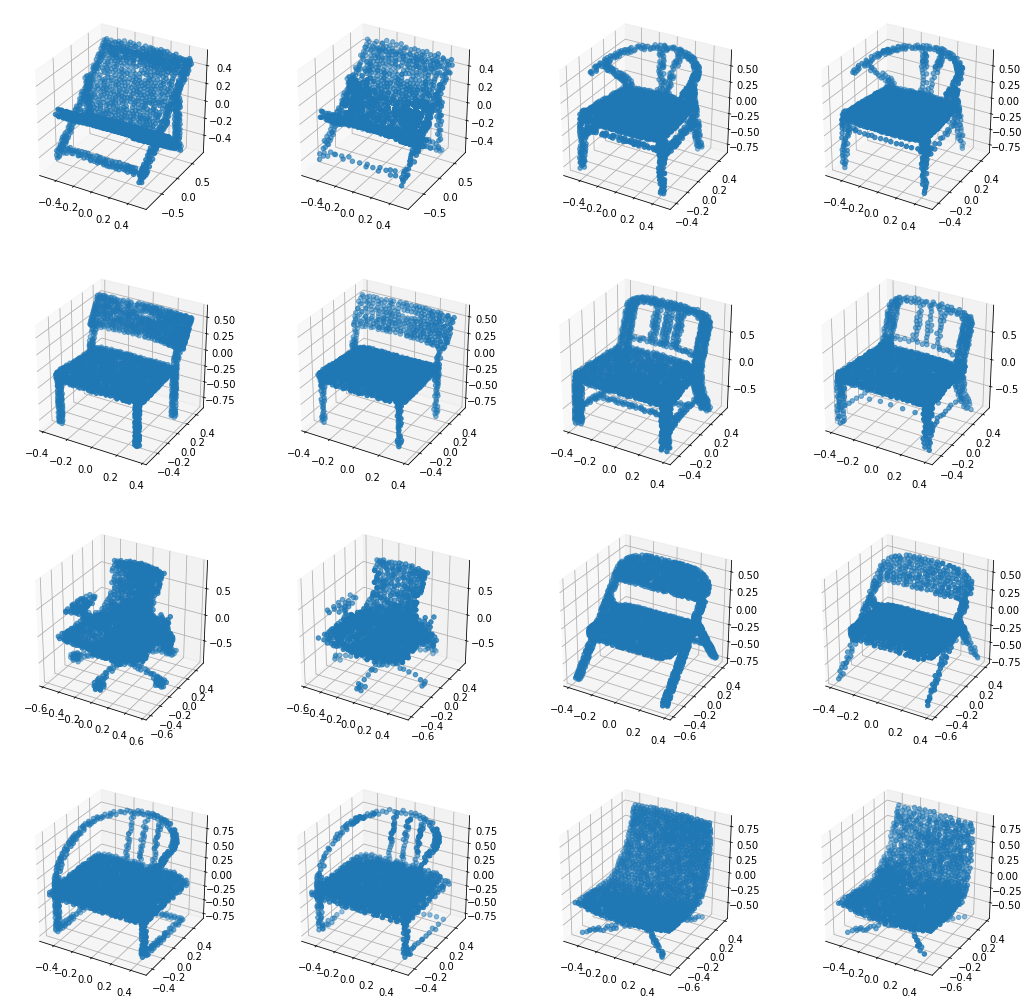

In [7]:
N, M = 4, 4
samples = batch_rec[:N*M]
plot_samples(samples, N, M)

# Interpolation

In [8]:
num_steps = 9

st = batch[:2]
st_means, _ = model.encode(st)
s_mean, t_mean = st_means
steps = [s_mean] + [s_mean + x*(t_mean-s_mean) for x in torch.linspace(0.3, 0.7, steps=num_steps-2)] + [t_mean]
steps = torch.stack(steps, dim=0)
interpolated = model.decode_at_mean(steps).reshape((num_steps,)+st[0].shape).detach()

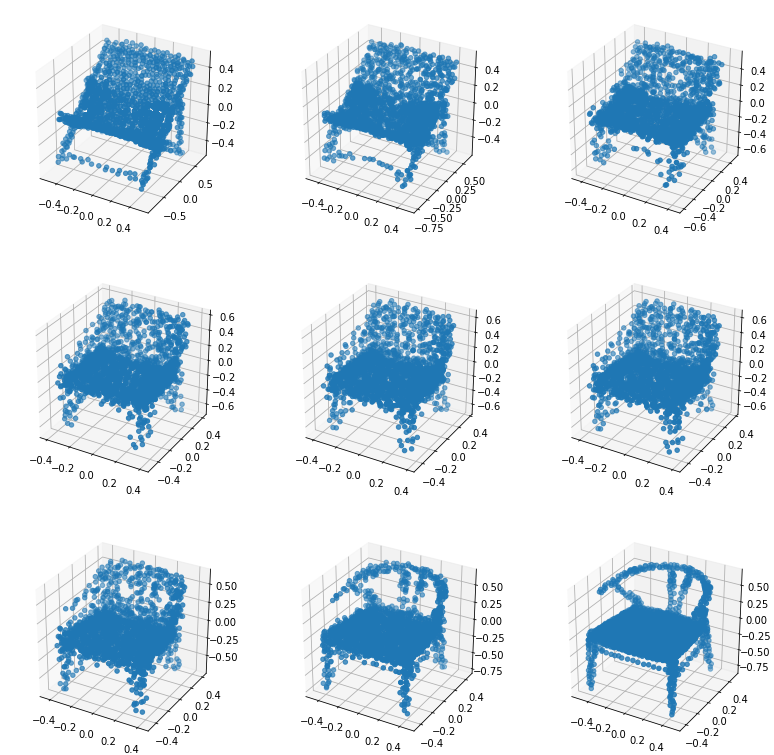

In [9]:
plot_samples(interpolated, 3, 3)

# Losowanie latentu

In [29]:
num_samples = 16

sample_shape = batch[0].shape
means, _ = model.encode(batch)
latent = means.shape[1]
z = 0.7*torch.randn(num_samples, latent)

rec = model.decode_at_mean(z).reshape((num_samples,)+sample_shape).detach()

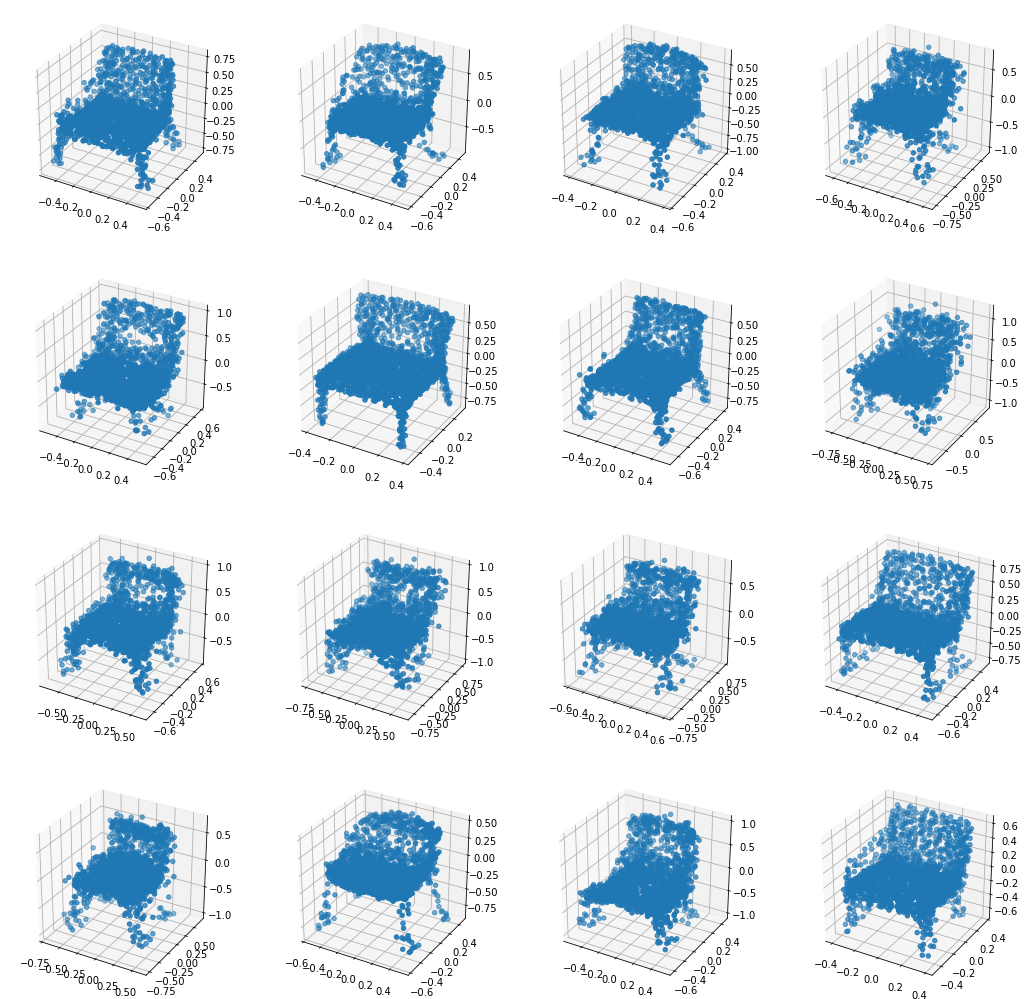

In [30]:
plot_samples(rec, 4, 4)

# Wykresy PCA i tSNE

In [22]:
latents_list = []
with torch.no_grad():
    for x, _ in test_loader:
        mean, sigma = model.encode(x)
        latents_list.append(mean)
latents = torch.cat(latents_list, dim=0).detach().numpy()

In [23]:
pca = PCA(n_components=2)
X, Y = pca.fit_transform(latents).T

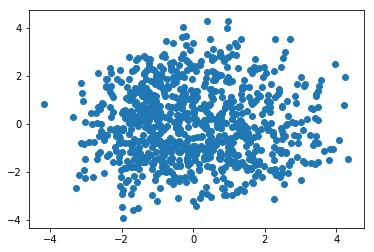

In [24]:
plt.scatter(X, Y)
plt.show()

In [25]:
tsne = TSNE(n_components=2)
X, Y = tsne.fit_transform(latents).T

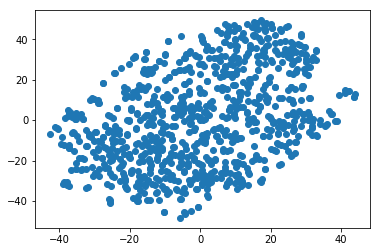

In [26]:
plt.scatter(X, Y)
plt.show()

# Coverage

In [29]:
recs_list = []
with torch.no_grad():
    for x, _ in test_loader:
        rec, _ = model(batch)
        recs_list.append(rec)
recs = torch.cat(recs_list, dim=0)

In [40]:
def nearest(sample, loader):
    best = float('inf')
    sample = sample.unsqueeze(0)
    with torch.no_grad():
        for x, _ in loader:
            y = sample.expand(x.shape[0], -1, -1)
            d = cd(x, y)
            d[d < 1e-4] += float('inf')
            best = min(best, torch.min(d).item())
    print(best)
    return best

def nearest_for_each(source_loader, target_loader):
    nearest_list = []
    with torch.no_grad():
        for x, _ in source_loader:
            nearest_list += [nearest(x[idx], target_loader) for idx in range(x.shape[0])]
    return torch.cat(nearest_list, dim=0)

In [41]:
recs_dataset = FromNpDataset(recs, np.zeros(recs.shape[0]))
recs_loader = DataLoader(recs_dataset, batch_size=32, shuffle=False, num_workers=2)

orig_to_orig = nearest_for_each(test_loader, test_loader)
orig_to_rec = nearest_for_each(test_loader, recs_loader)

float(torch.sum(orig_to_rec < orig_to_orig) / recs.shape[0])

1.1007072925567627
9.298713684082031
11.655862808227539
21.794307708740234
23.73135757446289
17.794227600097656
3.351473331451416
11.558488845825195


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/kubaz/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/kubaz/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/kubaz/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/kubaz/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/kubaz/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/kubaz/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/kubaz/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/Users/kubaz/

KeyboardInterrupt: 